Episode 0/500 - Score: 8.0 | Avg(50): 8.00 | ε: 1.0000
Episode 50/500 - Score: 206.0 | Avg(50): 160.52 | ε: 0.0100
✅ Environment solved at episode 99!
Episode 100/500 - Score: 226.0 | Avg(50): 295.42 | ε: 0.0100
Episode 150/500 - Score: 127.0 | Avg(50): 157.66 | ε: 0.0100
Episode 200/500 - Score: 159.0 | Avg(50): 80.88 | ε: 0.0100
Episode 250/500 - Score: 500.0 | Avg(50): 311.22 | ε: 0.0100
Episode 300/500 - Score: -2.0 | Avg(50): 263.90 | ε: 0.0100
Episode 350/500 - Score: 254.0 | Avg(50): 214.86 | ε: 0.0100
Episode 400/500 - Score: 390.0 | Avg(50): 318.46 | ε: 0.0100
Episode 450/500 - Score: 138.0 | Avg(50): 417.80 | ε: 0.0100


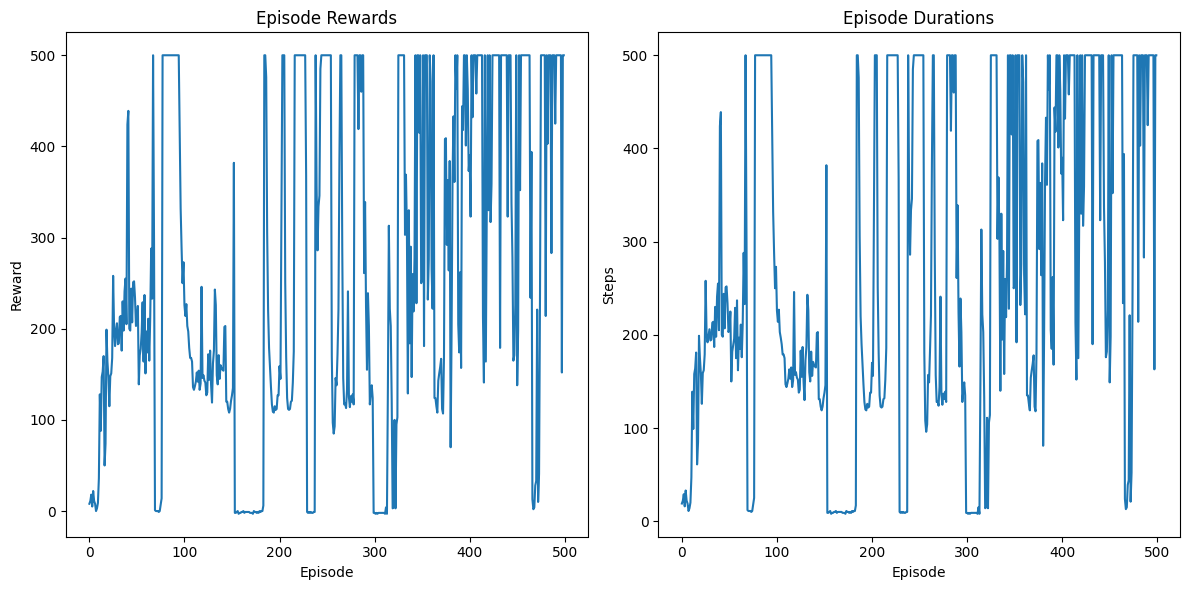

🎉 Successfully solved CartPole in 99 episodes!


In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# ========================
# 深度Q网络结构
# ========================
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

# ========================
# DQN代理 + 经验回放
# ========================
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.obs_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        
        # 主网络和目标网络
        self.model = DQN(self.obs_size, self.action_size)
        self.target_model = DQN(self.obs_size, self.action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        
        # 优化器及超参数
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)  # 经验池
        self.batch_size = 64
        self.gamma = 0.99  # 折扣因子
        self.epsilon = 1.0 # 初始探索率
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.update_freq = 10  # 目标网络更新频率
        self.train_step = 0
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return q_values.argmax().item()
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
            
        # 从经验池采样
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        
        # 转换为PyTorch张量
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones)
        
        # 计算当前Q值
        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # 计算目标Q值
        with torch.no_grad():
            max_next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + self.gamma * max_next_q * (~dones)
        
        # 计算损失并反向传播
        loss = nn.MSELoss()(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 更新目标网络
        if self.train_step % self.update_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())
            
        # 减少探索率
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.train_step += 1
        
        return loss.item()

# ========================
# 主训练函数
# ========================
def train_dqn(env, agent, episodes=500):
    scores = []
    episode_lengths = []
    solved_episode = None
    solved_threshold = 195  # CartPole的解决标准
    
    for e in range(episodes):
        # 重置环境
        if isinstance(env.reset(), tuple):
            state = env.reset()[0]  # 对于gymnasium新版
        else:
            state = env.reset()  # 对于gym旧版
            
        total_reward = 0
        step_count = 0
        done = False
        
        while not done:
            # 选择并执行动作
            action = agent.act(state)
            
            # 执行动作
            step_result = env.step(action)
            if len(step_result) == 4:  # 旧版
                next_state, reward, done, _ = step_result
                truncated = False
            else:  # 新版
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
                
            # 小技巧：添加额外奖励防止杆子倒下
            if done and step_count < 195:
                reward = -10  # 失败惩罚
                
            # 存储经验
            agent.remember(state, action, reward, next_state, done)
            
            # 训练模型
            loss = agent.replay()
            
            state = next_state
            total_reward += reward
            step_count += 1
            
            if done:
                break
                
        # 记录结果
        scores.append(total_reward)
        episode_lengths.append(step_count)
        
        # 检查是否解决环境
        if len(scores) >= 100 and np.mean(scores[-100:]) >= solved_threshold and solved_episode is None:
            solved_episode = e
            print(f"✅ Environment solved at episode {e}!")
        
        # 打印进度
        if e % 50 == 0:
            avg_score = np.mean(scores[-50:]) if e > 0 else scores[0]
            print(f"Episode {e}/{episodes} - Score: {total_reward} | Avg(50): {avg_score:.2f} | ε: {agent.epsilon:.4f}")
    
    # 可视化结果
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(scores)
    plt.title("Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    
    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths)
    plt.title("Episode Durations")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    
    plt.tight_layout()
    plt.savefig("dqn_results.png", dpi=300)
    plt.show()
    
    return solved_episode

# ========================
# 执行训练
# ========================
if __name__ == "__main__":
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    agent = DQNAgent(env)
    
    solved_ep = train_dqn(env, agent, episodes=500)
    
    if solved_ep:
        print(f"🎉 Successfully solved CartPole in {solved_ep} episodes!")
    else:
        print("⚠️ Failed to solve within 500 episodes. Trying more episodes...")
        solved_ep = train_dqn(env, agent, episodes=1000)
        if solved_ep:
            print(f"✅ Finally solved at episode {solved_ep}!")
        else:
            print("❌ Training unsuccessful. Please adjust hyperparameters.")